# Temperature Salinity Plots

In [52]:
import dask
import dask.array as da
import dask.dataframe as dd
import numpy as np
import xarray as xr

import bokeh.plotting as bp
from datashader.bokeh_ext import InteractiveImage

import matplotlib.pyplot as plt

In [16]:
from dask import delayed

In [2]:
import cosima_cookbook as cc

In [3]:
from distributed.diagnostics.progressbar import progress

In [18]:
import pandas as pd

In [13]:
client

NameError: name 'client' is not defined

In [14]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Client Scheduler: tcp://127.0.0.1:43823 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 20.20 GB


In [10]:
expt = 'KDS75'

In [38]:
temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp', n=1, 
                          time_units='days since 2000-01-01').sel(yt_ocean=slice(-60,-30))
salt = cc.get_nc_variable(expt, 'ocean.nc', 'salt', n=1, 
                          time_units='days since 2000-01-01').sel(yt_ocean=slice(-60,-30))


In [39]:
t_blocks = [x.reshape((-1,)) for x in temp.data.to_delayed().reshape((-1,))]
s_blocks = [x.reshape((-1,)) for x in salt.data.to_delayed().reshape((-1,))]
dfs = [delayed(pd.DataFrame)({'temp': t, 'salt': s}, copy=False) for t, s in zip(t_blocks, s_blocks)]

In [40]:
df = dd.from_delayed(dfs)

In [8]:
import datashader as ds
import datashader.transfer_functions as tf

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/odo/backends/pandas.py:102: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [41]:
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(df, 'salt', 'temp')
img = tf.shade(agg, cmap=['lightblue', 'darkblue'], how='log')

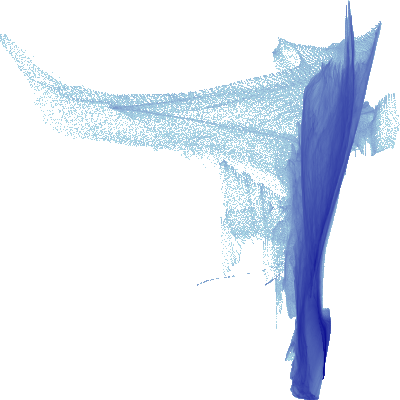

In [42]:
display(img)

In [44]:
# Default plot ranges:
y_range = (-2, 32) # temperature
x_range = (10, 40) # salinity

In [50]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.points(df, 'salt', 'temp')
    return tf.shade(agg, cmap=plt.cm.viridis_r)

In [53]:
bp.output_notebook()

def base_plot(tools='pan,wheel_zoom,box_zoom,reset'):
    p = bp.figure(tools=tools, plot_width=500, plot_height=500,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.axis_label = 'Practical Salinity'
    p.yaxis.axis_label = 'Potential Temperature'
    return p

p = base_plot()
InteractiveImage(p, create_image)

Loading BokehJS ...

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import xarray as xr

import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Hot

import dask.array as da
import dask.dataframe as dd
import dask
from dask.diagnostics import ProgressBar
from dask.cache import Cache

from datashader.bokeh_ext import InteractiveImage
import bokeh.plotting as bp

In [2]:
ProgressBar().register()
Cache(9e9).register()

Let's compare different ways of plotting TS diagrams.

In [3]:
filename = '/g/data1/v45/mom01_comparison/KDS75/output165/ocean.nc'

## Loading with netCDF4 and forming a pandas dataframe

In [4]:
%%time 

dataset = Dataset(filename)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 36.9 ms


In [37]:
dataset.variables['age_global']

<class 'netCDF4._netCDF4.Variable'>
float32 age_global(time, st_ocean, yt_ocean, xt_ocean)
    long_name: Age (global)
    units: yr
    valid_range: [  0.00000000e+00   1.00000002e+20]
    missing_value: -1e+20
    _FillValue: -1e+20
    cell_methods: time: mean
    time_avg_info: average_T1,average_T2,average_DT
    coordinates: geolon_t geolat_t
    standard_name: sea_water_age_since_surface_contact
unlimited dimensions: time
current shape = (1, 75, 2700, 3600)
filling on

In [17]:
%%time

temp = dataset.variables['temp'][:].compressed()
salt = dataset.variables['salt'][:].compressed()
age_global = dataset.variables['age_global'][:].compressed()

CPU times: user 53.5 s, sys: 6.35 s, total: 59.9 s
Wall time: 59.9 s


In [76]:
%%time
df = pd.DataFrame({'temp': temp, 'salt' : salt, 'age_global' : age_global}, copy=False)

CPU times: user 2.24 s, sys: 980 ms, total: 3.22 s
Wall time: 3.21 s


temp and salt are numpy MaskedArrays
.compressed() returns a 1d array where the masked elements have been removed.

In [32]:
# Default plot ranges:
y_range = (-2, 32) # temperature
x_range = (10, 40) # salinity

In [40]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.points(df, 'salt', 'temp', ds.mean('age_global'))
    return tf.shade(agg)

In [78]:
%%time
cvs = ds.Canvas(plot_width=500, plot_height=500,x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'salt', 'temp')

CPU times: user 10.9 s, sys: 4 ms, total: 11 s
Wall time: 10.9 s


/home/v45/miniconda3/envs/cosima/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


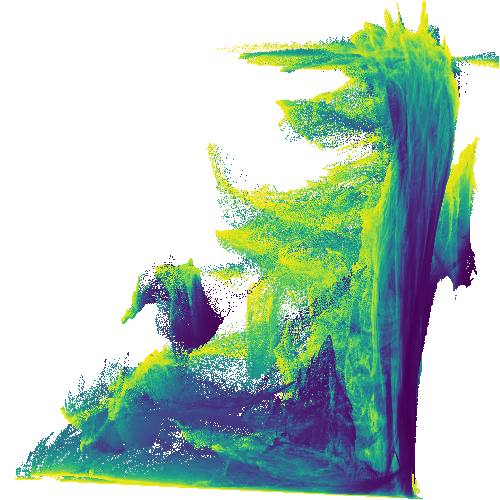

In [66]:
img = tf.shade(agg, cmap=plt.cm.viridis_r)
img

In [48]:
bp.output_notebook()

def base_plot(tools='pan,wheel_zoom,box_zoom,reset'):
    p = bp.figure(tools=tools, plot_width=500, plot_height=500,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.axis_label = 'Practical Salinity'
    p.yaxis.axis_label = 'Potential Temperature'
    return p

p = base_plot()
InteractiveImage(p, create_image)

Loading BokehJS ...

 ## Use dask.dataframe instead of pandas dataframe

In [5]:
%%time
dataset = Dataset(filename)

temp = dataset.variables['temp'][:].compressed()
salt = dataset.variables['salt'][:].compressed()
age_global = dataset.variables['age_global'][:].compressed()


CPU times: user 1min 21s, sys: 10.1 s, total: 1min 31s
Wall time: 1min 31s


In [97]:
%%time
df_dd = dd.from_array(np.array([temp, salt]).T, columns=['temp', 'salt'])

CPU times: user 9.26 s, sys: 16 ms, total: 9.27 s
Wall time: 40.2 s


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 535, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 520, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt


In [85]:
cvs = ds.Canvas(plot_width=500, plot_height=500,x_range=x_range, y_range=y_range)
agg = cvs.points(df_dd, 'salt', 'temp')

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed | 17.8s


Although the dask dataframe is using threads, there is no speed up.

## Load data using dask

In [90]:
dask.set_options(get=dask.multiprocessing.get, num_workers=4)

In [98]:
cvs.points

<bound method Canvas.points of <datashader.core.Canvas object at 0x7f61e0da8eb8>>

In [91]:
cvs = ds.Canvas(plot_width=500, plot_height=500,x_range=x_range, y_range=y_range)
agg = cvs.points(df_dd, 'salt', 'temp')

[                                        ] | 0% Completed | 31.5s

Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-15:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 249, in _boot

[                                        ] | 0% Completed | 31.6s

  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
Traceback (most recent call last):
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing

KeyboardInterrupt: 

  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Process ForkPoolWorker-7:
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/v45/miniconda3/envs/cosima/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/hom

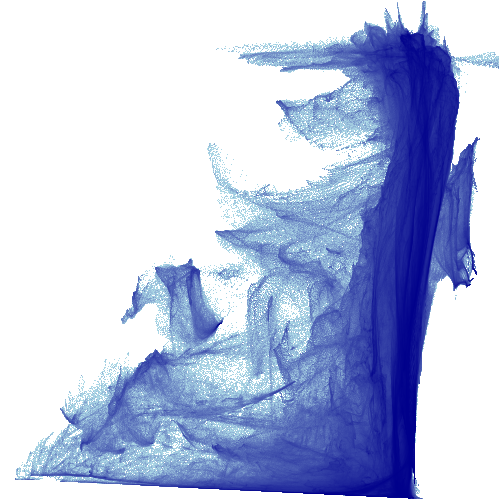

In [74]:
tf.shade(agg)

In [2]:
from dask.distributed import Client, LocalCluster

In [23]:
cluster.status

'closed'

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)

In [4]:
client = Client(cluster)

In [21]:
client.restart()

<Client: scheduler='tcp://127.0.0.1:8786' processes=0 cores=0>

In [2]:
filename = '/g/data1/v45/mom01_comparison/KDS75/output165/ocean.nc'

In [3]:
dsx = xr.open_dataset(filename, decode_times=False)

In [ ]:
# convert to pandas dataframe
%time df = dsx.temp.to_dataframe()

In [ ]:
# convert to pandas dataframe
%time df = dsx.temp.to_dataframe()

In [ ]:
%time df2 = dsx.salt.to_dataframe()

In [ ]:
df3 = df.merge(df2)

In [ ]:
stacked = dsx.temp.stack(z = ('st_ocean', 'xt_ocean', 'yt_ocean'))

In [ ]:
stacked.z

In [ ]:
%time dataset.u.plot.hist(bins=100)

In [ ]:
%%time 
agg = cvs.points(df, 'geolon_t', 'geolat_t', ds.count('temp'))

img = tf.shade(agg, how='log')
img

In [ ]:
img = tf.shade(agg, how='log')

In [ ]:
from dask import delayed

@delayed
def get_data(key):
    ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
    h5 = h5py.File(ncfile, mode='r')
    arr = dd.from_array(h5['/'+key][:].ravel(), columns = [key])
    h5.close()
    return arr

temp = get_data('temp')
print('temp loaded')
salt = get_data('salt')
print('salt loaded')

#arr = delayed(np.hstack)((temp, salt))
print(arr.shape)
#df = delayed(dd.from_array)( arr, columns = ['temp', 'salt'])
print(df)

In [ ]:
ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
dsx = xr.open_dataset(ncfile, decode_times=False, engine='h5netcdf')

In [ ]:
from dask import delayed

@delayed
def get_data(key):
    ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
    dsx = xr.open_dataset(ncfile, decode_times=False, engine='h5netcdf')
    arr = dsx.variables(key).values.ravel()
    dsx.close()
    return arr

df = dd.from_array( np.array( [ dsx.temp.values.ravel(), dsx.salt.values.ravel()]).T, 
              columns=['temp', 'salt'])

In [ ]:
dsx = xr.open_dataset(ncfile, decode_times=False, engine='h5netcdf', chunks={'st_ocean':1, 'sw_ocean':1})

In [ ]:
%%time
df = dd.from_array( np.array( [ dsx.temp.values.ravel(), dsx.salt.values.ravel()]).T,
                  columns = ('temp', 'salt'))

In [ ]:
df = delayed(dd.merge)(temp, salt)

In [ ]:
df.visualize()

In [ ]:
%%time
df2 = df.compute()

In [ ]:
ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
dd.read_hdf(ncfile, 'temp')